<a href="https://colab.research.google.com/github/leksandre/-crab-for-web2ipr_book_shop/blob/main/test_stroyka_(%D0%B1%D0%B5%D0%B7_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F)_kaggle_dataset1_(normal_work).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/MyDrive/best.pt

Mounted at /content/gdrive
/content/gdrive/MyDrive/best.pt


In [2]:
!cp /content/gdrive/MyDrive/best.pt  /content

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'construction-site-safety-image-dataset-roboflow:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2919095%2F5048288%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T113428Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7fd7070e1f1d72a7d2578e902e3259adc119da4d6b8af22250d95e00b88e0fed24074825470f653aa0320c08caa8f130fcfa677337aa626fd71ee9881c1e913c898fb31c56a140fe4d57d8dc1e1238fd99252135046eb50a50b026f85c626d7f9195601cab472501d949b922abae962d0612bac53b2e301a74e334d8bb213b3d386f44255bac547e015d9ed2671edb0165102f927e229830cba58241a7122a4ba1b6ec59872c4de978173146f5dd68faf2aef4495cb60bffc1b633fadc754944d92134b36c2a4ce62910d6093d50a48b75543b5b88303185598cf8700261ac1246e82d38cc1fa32afce0915ff5aacac0ba8d361c2a7e3535a19c8ccf24e8e095'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 216024261 bytes downloaded
Downloaded and uncompressed: construction-site-safety-image-dataset-roboflow
Data source import complete.


In [ ]:
pip install ultralytics==8.1.42

In [5]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2


In [6]:
warnings.filterwarnings("ignore")

np.random.seed(12345)

%matplotlib inline

!wandb disabled

/bin/bash: line 1: wandb: command not found


In [7]:
Input_path = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data'
Work_path = '/kaggle/working/'

In [8]:
num_classes = 10
classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [9]:
dict_file = {'train': os.path.join(Input_path, 'train'),
             'val': os.path.join(Input_path, 'valid'),
             'test': os.path.join(Input_path, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(Work_path, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [10]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(Input_path, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

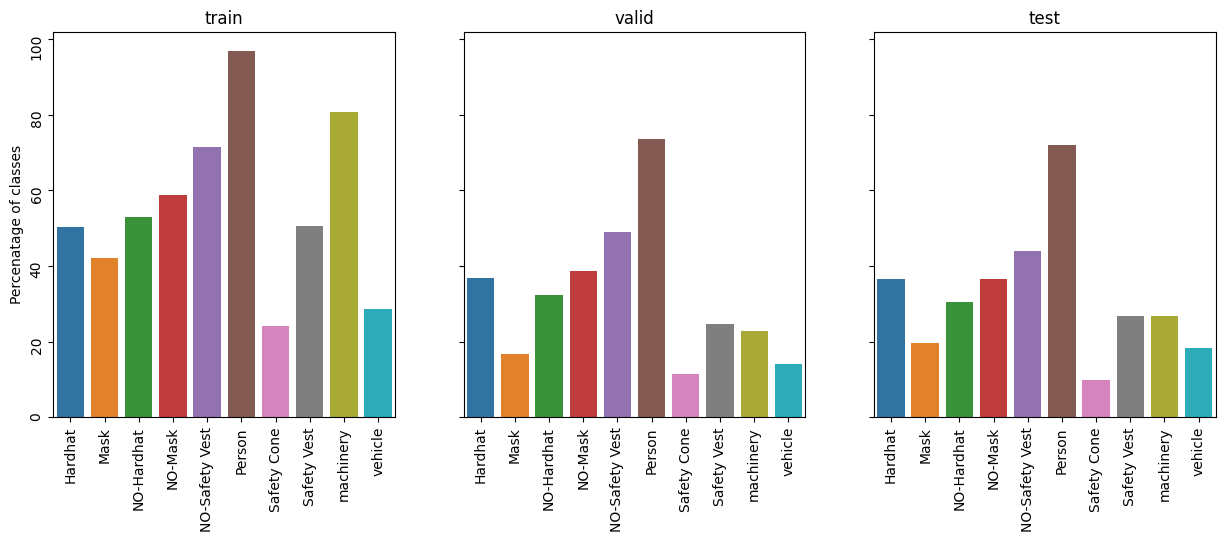

In [11]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

In [12]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(Input_path, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(640, 640)

Image sizes in valid set:

	(640, 640)

Image sizes in test set:

	(640, 640)


In [13]:
for mode in ['train', 'valid', 'test']:

    files =  glob.glob(os.path.join(Input_path, mode, 'images', '*'))

    print(f'{mode} set size: {len(files)}\n')

train set size: 2605

valid set size: 114

test set size: 82



- Load `pre-trained` YOLO-nano model

In [14]:
model = YOLO('best.pt')

In [15]:
results = model.predict(source=os.path.join(Input_path, 'test', 'images'), save=True)


image 1/82 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 2 Persons, 12.0ms
image 2/82 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 2 Hardhats, 1 NO-Mask, 1 NO-Safety Vest, 2 Persons, 10.7ms
image 3/82 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Hardhats, 2 NO-Masks, 2 NO-Safety Vests, 2 Persons, 12.4ms
image 4/82 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Hardhat, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 1 Safety Cone, 11.3ms
image 5/82 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 5 Hardhats, 5 N

In [19]:
%matplotlib inline
import random
predicitions = glob.glob(os.path.join(Work_path, '/kaggle/working/runs/detect/predict', '*'))
n1 = len(predicitions)
print('len(predicitions)',n1)
n = 10
if n1 == 0:
  # paht = '/content/predict/*'
  paht = 'runs/detect/predict/*'
  # paht = '/kaggle/input/construction-site-safety-image-dataset-roboflow/source_files/source_files/*'
  print('paht',paht)
  predicitions = glob.glob(paht)
  n1 = len(predicitions)
  print('2 len(predicitions)',n1)



len(predicitions) 0
paht runs/detect/predict/*
2 len(predicitions) 82


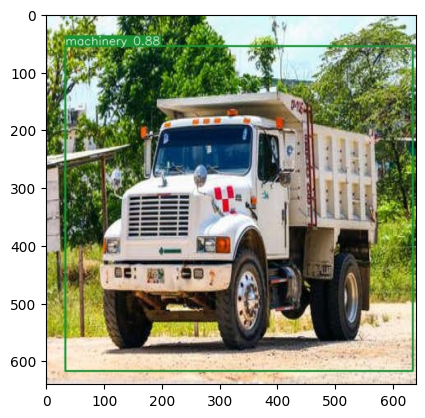

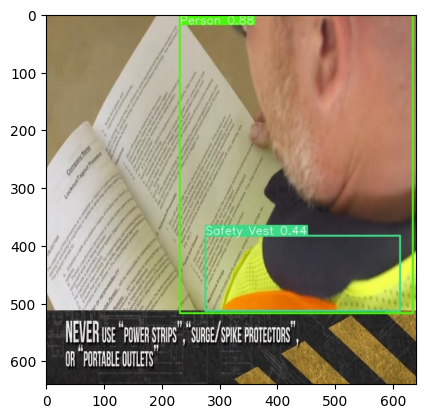

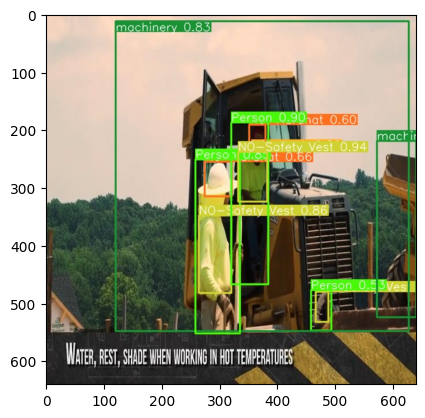

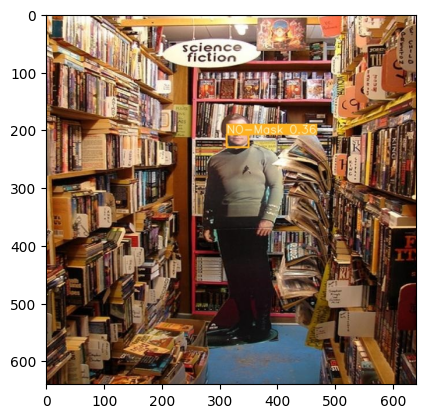

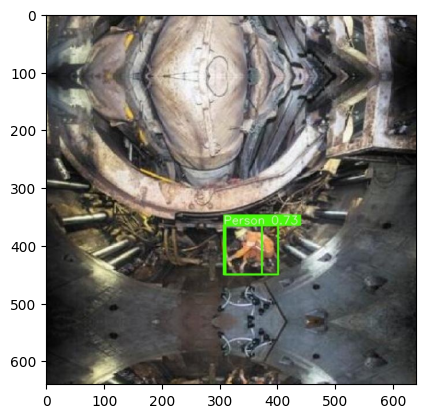

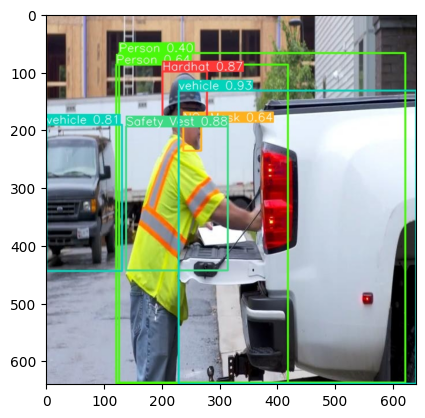

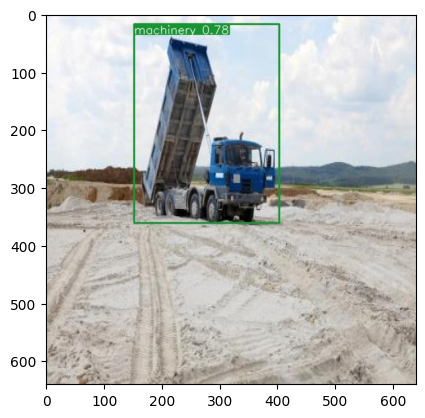

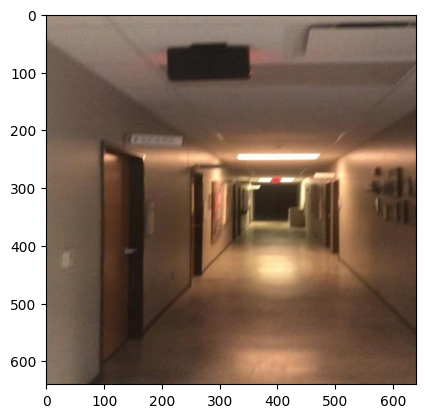

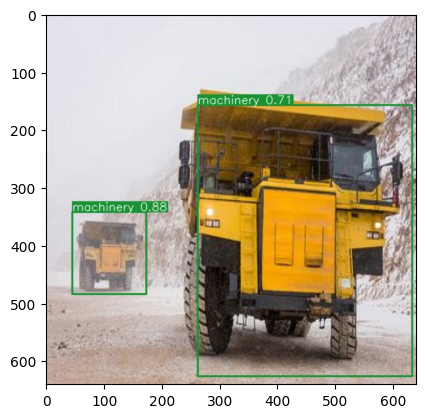

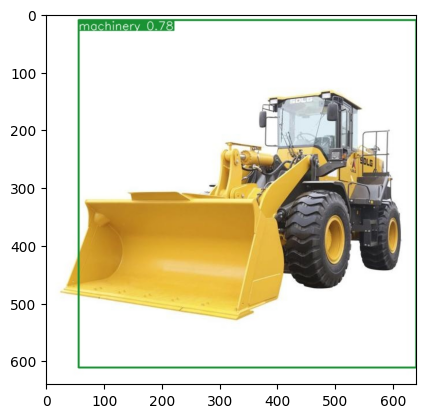

In [20]:
if n1>0:
  for i in range(n):
    idx = random.randint(0, n1-1)
    if predicitions[idx].find('.mp4')>0:
      continue
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()

In [18]:
# from IPython.display import display, FileLink

# local_file = FileLink('runs/detect/yolov8n_v1_train/weights/best.pt', result_html_prefix="Click here to download: ")
# display(local_file)